# Detect and Track Example

This notebook demonstrates detecting and tracking objects in a video stream.

## Preparation

First, we need to import the necessary packages.

In [1]:
!pip install --quiet -e ../../

%load_ext autoreload
%autoreload 2

In [ ]:
## How to

In [2]:
import os
import sys

import numpy as np
from rich import print, inspect
from soccertrack.utils import load_config, write_config
from soccertrack.utils.camera import load_cameras, find_intrinsic_camera_parameters
from soccertrack.detect import detect_objects
from soccertrack.utils import cv2pil
from soccertrack.utils.detection import CandidateDetection

from mplsoccer import Pitch
import matplotlib.pyplot as plt
import numpy as np

cfg = load_config('./detect_and_track.yaml')
cameras = load_cameras(cfg['cameras'])

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

In [3]:
# detection
"""
TODO: detection checklist
    - return results as list of Detection Objects -> OK
    - option to visualize detections? 
    - aggregate detections from multiple cameras? 
    - drop detections that are out of bounds -> OK
    - Are detection results visualized and saved?
"""
player_detections, ball_detections = detect_objects(
    cameras,
    model_name='yolov5m',
    size=1500,
    batch_size=4,
    filter_range=False
)

print("N ball detections:", sum(len(x) for x in ball_detections.values()))
print("N player detections:", sum(len(x) for x in player_detections.values()))

Using cache found in /home/atom/.cache/torch/hub/ultralytics_yolov5_master
YOLOv5 🚀 2021-12-28 torch 1.10.0+cu102 CUDA:0 (GeForce GTX 1080 Ti, 11178MiB)

Fusing layers... 
Model Summary: 290 layers, 21172173 parameters, 0 gradients
Adding AutoShape... 


0it [00:00, ?it/s]

0it [00:00, ?it/s]

N ball detections: 932

N player detections: 8700

In [4]:
def merge_dict_of_lists(d1, d2):
    ret = {k:list(v) for k,v in d1.items()}
    for k, v in d1.items():
        if k in d2.keys():
            ret[k] += d2[k]
        else:
            ret[k] = d2[k]
    return ret

all_candidate_detection = merge_dict_of_lists(ball_detections, player_detections)

In [5]:
from IPython.display import Video, display


for i, camera in enumerate(cameras):
    save_path = os.path.join(cfg.outdir, f'camera[{i}]-visualize_candidate_detections.mp4')
    camera.visualize_candidate_detections(
        candidate_detections=all_candidate_detection, 
        filter_range=False,
        save_path=save_path
        )
    display(Video(save_path, width=600))


0it [00:00, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

0it [00:00, ?it/s]

  0%|          | 0/250 [00:00<?, ?it/s]

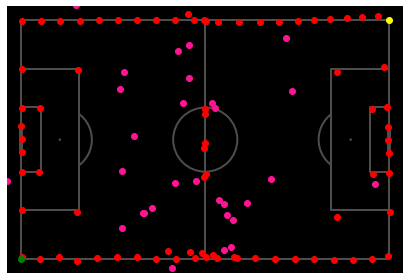

In [6]:
%matplotlib inline

i=20

xs,ys =[],[]
for pd in player_detections[i]:
    if pd.camera.label == cameras[0].label:
        px, py = cameras[0].video2pitch(np.array([pd._x, pd._y])).squeeze()
    elif pd.camera.label == cameras[1].label:
        px, py = cameras[1].video2pitch(np.array([pd._x, pd._y])).squeeze()
    else:
        raise ValueError("camera label not found")
    xs.append(px)
    ys.append(py)

kxs,kys =[],[]
for camera in cameras:
    for x, y in camera.source_keypoints:
        x, y = camera.video2pitch(np.array([x, y])).squeeze()
        kxs.append(x)
        kys.append(y)

def get_xsys(detections, cameras):
    if isinstance(detections, dict):
        detections = list(detections.values())
        
    xs,ys =[],[]
    for dets in detections:
        if isinstance(dets, CandidateDetection):
            dets = [dets]
        for pd in dets:
            if pd.camera.label == cameras[0].label:
                px, py = cameras[0].video2pitch(np.array([pd._x, pd._y])).squeeze()
            elif pd.camera.label == cameras[1].label:
                px, py = cameras[1].video2pitch(np.array([pd._x, pd._y])).squeeze()
            else:
                raise ValueError("camera label not found")
            
            assert px == pd.px, (px, pd.px)
            assert py == pd.py, (py, pd.py)
            xs.append(px)
            ys.append(py)
    return xs,ys

pitch = Pitch(pitch_color='black', line_color=(.3,.3,.3), pitch_type='custom', pitch_length=105, pitch_width=68) 
fig, ax = pitch.draw()
plt.scatter(xs, ys, color='deeppink')
plt.scatter(kxs, kys, color='red')
plt.scatter(0,0, color='green')
plt.scatter(105,68, color='yellow')
plt.show()

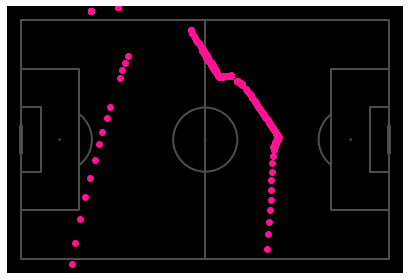

In [7]:
# before pitch reconstruction
pitch = Pitch(pitch_color='black', line_color=(.3,.3,.3), pitch_type='custom', pitch_length=105, pitch_width=68) 
fig, ax = pitch.draw()
xs, ys = get_xsys(ball_detections, cameras)
plt.scatter(xs, ys, color='deeppink')
plt.show()

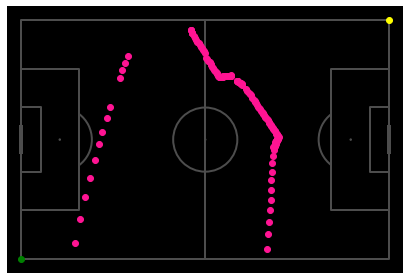

In [8]:
# ball trajectory reconstruction
# filter ball where in_range is False
ball_detections_ir = {k: [vi for vi in v if vi.in_range] for k,v in ball_detections.items()}

# before pitch reconstruction
pitch = Pitch(pitch_color='black', line_color=(.3,.3,.3), pitch_type='custom', pitch_length=105, pitch_width=68) 
fig, ax = pitch.draw()
xs, ys = get_xsys(ball_detections_ir, cameras)
plt.scatter(xs, ys, color='deeppink')
plt.scatter(0,0, color='green')
plt.scatter(105,68, color='yellow')

plt.show()

In [18]:
from scipy.spatial.distance import cdist, euclidean
from scipy.optimize import linear_sum_assignment

from soccertrack.utils.tracking import Track
from soccertrack.utils import logger

def cost(X, Y, feature, func):
    x_feature = getattr(X, '_feature_'+feature)
    y_feature = getattr(Y, '_feature_'+feature)
    return func(x_feature, y_feature)

def cdist(detections, tracks, funcs, reduction='mean'):
    
    costs = []
    for func in funcs:
        C = np.zeros((len(detections), len(tracks)))

        for di, detection in enumerate(detections):
            for ti, track in enumerate(tracks):
                C[di, ti] = cost(detection, track, feature='xy', func=func)
        costs.append(C)
            
    if reduction == 'mean':
        return np.mean(costs, axis=0)
    else:
        raise NotImplementedError(f"reduction(`{reduction}`) not implemented")

detections = ball_detections[0]
tracks = [Track(0,0), Track(32,14)]
cdist(detections, tracks, funcs=[euclidean])

array([[     76.799,      57.867],
       [     79.688,      60.495],
       [     73.396,      57.882]])

In [14]:
inspect(detections[0]._class_id)

╭────── <class 'int'> ───────╮
│ int([x]) -> integer        │
│ int(x, base=10) -> integer │
│                            │
│ ╭────────────────────────╮ │
│ │ 32                     │ │
│ ╰────────────────────────╯ │
│                            │
│ denominator = 1            │
│        imag = 0            │
│   numerator = 32           │
│        real = 32           │
╰────────────────────────────╯

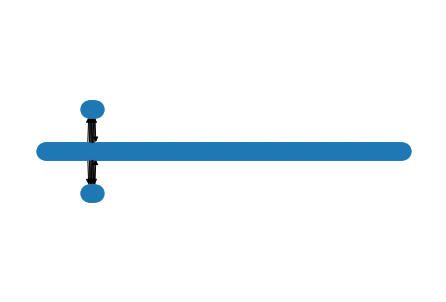

In [68]:
import networkx as nx

def calculate_weight(n1, n2):
    return np.random.randint(1, 10, 1)


# Generate Graph
G = nx.DiGraph(capacity=1)

timesteps = range(max(ball_detections.keys()))
G.add_node('start', frame_idx=-1, class_id=-1)
previous_nodes = ['start']

min_detections = 1
for timestep in timesteps:
    next_nodes = []
    detections = [detection for detection in ball_detections[timestep] if detection.in_range]

    for di, detection in enumerate(detections):
        assert detection.frame_idx == timestep, (detection.frame_idx, timestep)

        node_id = f"{detection.frame_idx}_{di}_{detection.camera.label}_{detection._class_id}"
        G.add_node(node_id, frame_idx=timestep, class_id = detection._class_id)
        next_nodes.append(node_id)

        for prev_node in previous_nodes:
            G.add_edge(prev_node, node_id, weight=calculate_weight(G.nodes[prev_node], G.nodes[node_id]))

    if len(detections) < min_detections:
        for pi in range(min_detections - len(detections)):
            node_id = f"placeholder_{timestep}_{pi}"
            G.add_node(node_id, frame_idx=timestep, class_id = -1)
            next_nodes.append(node_id)

            for prev_node in previous_nodes:
                G.add_edge(prev_node, node_id, weight=calculate_weight(G.nodes[prev_node], G.nodes[node_id]))
    
    previous_nodes = next_nodes
    
G.add_node('end', frame_idx=timestep+1, class_id=-1)
for prev_node in previous_nodes:
    G.add_edge(prev_node, 'end', weight=calculate_weight(G.nodes[prev_node], G.nodes[node_id]))


pos = nx.multipartite_layout(G, subset_key='frame_idx')
nx.draw(G, pos)

flow_dict = nx.min_cost_flow(G)



In [103]:

funcs=[euclidean]
timesteps = list(ball_detections.keys())
for timestep in timesteps:
    detections = ball_detections[timestep]

    # initialize trackers
    if timestep == 0:
        tracks = [Track(34) for _ in detections]

    # generate cost matrix
    cost_matrix = cdist(detections, tracks, funcs)

    # calculate hungarian assignment
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # update tracks
    for di, ti in zip(row_ind, col_ind):
        if timestep != 0:
            logger.debug(f"{detections[di]._feature_xy} -> {tracks[ti].detections[-1]._feature_xy}")
        tracks[ti].detections.append(detections[di])


IndexError: list index out of range

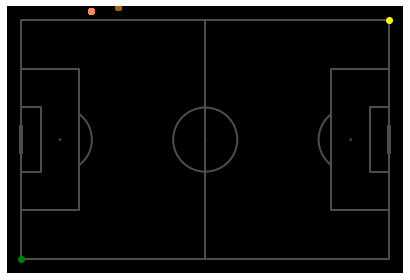

In [102]:
# before pitch reconstruction
pitch = Pitch(pitch_color='black', line_color=(.3,.3,.3), pitch_type='custom', pitch_length=105, pitch_width=68) 
fig, ax = pitch.draw()

for track in tracks:
    xs, ys = get_xsys(track.detections, cameras)
    plt.scatter(xs, ys, color=np.random.rand(3,))

plt.scatter(0,0, color='green')
plt.scatter(105,68, color='yellow')

In [ ]:
df = pd.concat(df_list) # necessary for restart
df = df.sort_values('frame') 

# ball trajectory reconstruction
xs, ys, ts = df[(df['name']=='sports ball') & (df['confidence']>=.5) & (df['drop']==False)][['x', 'y', 'frame']].values.T

ts_range = range(int(ts[0]), int(ts[-1]+2))
xs2 = [np.nan for _ in ts_range]
ys2 = [np.nan for _ in ts_range]

for i, _ in enumerate(ts):
    xs2[int(ts[i])] = xs[i]
    ys2[int(ts[i])] = ys[i]
    
xs = np.array(xs2)
ys = np.array(ys2)

for _ in range(3):
    xs = fill_nan(xs)
    ys = fill_nan(ys)
    ds = np.sqrt(np.diff(xs, 1, append=xs[-1:]) ** 2 + np.diff(ys, 1, append=ys[-1:]) ** 2)
    
    xs = smooth(xs, 3)
    ys = smooth(ys, 3)
    ds = smooth(ds, 3)
    xs[ds>1.] = np.nan
    ys[ds>1.] = np.nan

    xs = fill_nan(xs)
    ys = fill_nan(ys)

# try to update main dataframe
for t in tqdm(ts_range):
    if len(df.loc[(df['name']=='sports ball') & (df['drop']==False) & (df['frame']==t)]) == 0:
        df = df.append([{
            'name':'sports ball',
            'drop':False,
            'frame':t,
            'x': xs[t],
            'y': ys[t]
        }])
    else:
        # dupes r fuk
        df.loc[(df['name']=='sports ball') & (df['drop']==False) & (df['frame']==t), 'x'] = xs[t]
        df.loc[(df['name']=='sports ball') & (df['drop']==False) & (df['frame']==t), 'y'] = ys[t]